# Introduction

In [0]:
!pip install keras-tqdm

In [2]:
import os 
import tensorflow as tf
import librosa
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
print(tf.__version__)

# Keras stuff
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, LSTM, Dropout, Activation, Conv1D, MaxPooling1D, BatchNormalization, Lambda
from keras.optimizers import Adam
from keras import regularizers
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# from keras_tqdm import TQDMNotebookCallback

# Kapre stuff
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from kapre.augmentation import AdditiveNoise


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1.14.0


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


All custom functions (besides models) are put here.

In [0]:
dict_genres_small = {'Electronic':1, 'Experimental':2, 'Folk':3, 'Hip-Hop':4, 
               'Instrumental':5,'International':6, 'Pop' :7, 'Rock': 8  }


dict_genres_med = {'Hip-Hop':1, 'Pop':2, 'Rock':3, 'Folk':4, 'Experimental':5, 'Jazz':6,
       'Electronic':7, 'International':8, 'Soul-RnB':9, 'Blues':10, 'Spoken':11,
       'Country':12, 'Classical':13, 'Old-Time / Historic':14, 'Instrumental':15,
       'Easy Listening':16}

def track_id_from_directory(audio_dir):
    """
    Get track IDs from the mp3s in a directory.
    Parameters
    ----------
    audio_dir : str
        Path to the directory where the audio files are stored.
    Returns
    -------
        A list of track IDs.
    """
    track_ids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            track_ids.extend(int(file[:-4]) for file in files)
    return track_ids


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    track_id_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, track_id_str[:3], track_id_str + '.mp3')

def unique_shapes(X):
    shapes = set([])
    for arr in X:
        shapes.add(arr.shape[1])
    return shapes


def prepare_mp3s_and_labels(audio_dir, track_ids, meta_df, len_second=1.0):
    sources = []
    sample_rates = []
    genres = []
    split_labels=[]
    count = 0
    for tr_id in track_ids:
        try:
            count+=1
            src, sr = librosa.load(
                get_audio_path(audio_dir, tr_id),
                sr=None, mono=True
            )

            # trims the src file to be the correct length
            src = src[:int(sr * len_second)]

            # adds a new axis
            src = src[np.newaxis, :]

            sources.append(src)
            sample_rates.append(sr)

            # append the genre from metadata
            genres.append(meta_df.loc[ meta_df['track_id'] == tr_id, ('track','genre_top')].values[0])

            # append splitting labels
            split_labels.append(meta_df.loc[ meta_df['track_id'] == tr_id, ('set','split')].values[0])

            if (count%100 == 0):
                print("Finished step %s." % count)
        except :
            print("Could not process track id %s because of a runtime error." % tr_id)
            continue
            
    genres = np.array(genres)

    # trim the songs so that they can be put into a numpy array.
    shapes = unique_shapes(sources)
    min_song_len = min(shapes)
    for idx in range(len(sources)):
        sources[idx] = sources[idx][:, :min_song_len]
    
    
    return np.stack(sources), sample_rates, genres, split_labels


def train_val_test_split(X, y, split_labels):
    """ 
    Take split labels and split X and y into train, validation, and test sets. Also subtract 1 so that classes go from 0, ..., n-1.
    """
    assert len(X)==len(y) and len(y) == len(split_labels)
    
    # slide the scale down by 1.
    y = y - 1
    
    return X[split_labels=='training'], y[split_labels=='training'], X[split_labels=='validation'], y[split_labels=='validation'], X[split_labels=='test'], y[split_labels=='test']



def show_summary_stats(history, save = False, filename=''):
    # List all data in history
    print(history.history.keys())

    fig = plt.figure(figsize = (10,10))
    
    # Summarize history for accuracy
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.axhline(y= np.max(history.history['val_acc']), color = 'r', linestyle='--', label = 'best acc')
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='best')

    # Summarize history for loss
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='best')

    if save==True:
        plt.savefig(filename+'.png')
    
    
    
    plt.show()
    
    
def train_and_fit(model, X_train, y_train, X_valid, y_valid, X_test, y_test, lr=0.001, batch_size=32, num_epochs = 50):
    
    # Compile the model
    opt=Adam(lr=lr)

    model.compile( loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'] ) 
    
    checkpoint_callback = ModelCheckpoint(os.path.join(colab_dir, 'models/crnn/weights.best.h5'), monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    reducelr_callback = ReduceLROnPlateau( monitor='val_acc', factor=0.5, patience=5, min_delta=0.01, verbose=1 )
    early_stop = EarlyStopping(monitor='val_acc', patience = 15, verbose = 1, restore_best_weights = True)
    callbacks_list = [checkpoint_callback, reducelr_callback, early_stop, TQDMNotebookCallback()]
    
    history = model.fit(X_train, to_categorical(y_train), batch_size=batch_size, epochs=num_epochs, validation_data=(X_valid, to_categorical(y_valid)), verbose=0, callbacks = callbacks_list)
    
    valid_out = model.evaluate(X_valid, to_categorical(y_valid), verbose=0)
    test_out = model.evaluate(X_test, to_categorical(y_test), verbose=0)
    
    print('Validation loss: {0:.2f} -- acc: {1:.2f}'.format(*valid_out))
    print('Test loss: {0:.2f} -- acc: {1:.2f}'.format(*test_out))
    
    return history

In [0]:
# directories for raw audio files

# audio_dir_small = 'fma_small/'
# audio_dir_med = os.path.join('A:',os.sep,'large_datasets','fma_medium')
# audio_dir_med = os.path.expanduser('~/Documents/datasets.nosync/fma/fma_medium/')

#colab directory
colab_dir = '/content/drive/My Drive/music_npz_files'

Need these in order to get the labels.

In [0]:
metadata_fp = os.path.join(colab_dir, 'tracks.csv')
# metadata_fp = '/content/drive/My Drive/music_npz_files/tracks.csv'
# metadata_fp = os.path.join('/content/drive', 'music_npz_files', 'tracks.csv')
tracks = pd.read_csv(metadata_fp, index_col=0, header=[0,1])

# Dwivedi's CRNN on the FMA-Small dataset

## Preprocessing

In [0]:
cols_to_keep = [('set','split'), ('set', 'subset'), ('track', 'genre_top')]
# ('track', 'genres') might be included to make a better model since some tracks don't have a top genre.

df_small = tracks[cols_to_keep]
df_small = df_small[ df_small[('set','subset')] == 'small']
df_small['track_id'] = df_small.index

In [13]:
df_small.head(10)

set                track track_id
               split subset     genre_top         
track_id                                          
2           training  small       Hip-Hop        2
5           training  small       Hip-Hop        5
10          training  small           Pop       10
140         training  small          Folk      140
141         training  small          Folk      141
148       validation  small  Experimental      148
182             test  small          Rock      182
190         training  small          Folk      190
193         training  small          Folk      193
194         training  small          Folk      194

In [20]:
df_small.loc[df_small['track_id']==2,('track','genre_top')].values[0]

'Hip-Hop'

In [0]:
small_track_ids = track_id_from_directory(audio_dir_small)

In [0]:
# X_full, sample_rates, y_full, split_labels = prepare_mp3s_and_labels(audio_dir, track_ids, df_all)

In [0]:
# np.savez('full_processed_arr.npz', X_full, y_full, split_labels, sample_rates)

In [0]:
npzfile = np.load(os.path.join(colab_dir,'small_processed_arr.npz'))

X_full = npzfile['arr_0']
y_full = npzfile['arr_1']
split_labels = npzfile['arr_2']
sample_rates = npzfile['arr_3']

(7997, 1, 22050) (7997,)


In [0]:
X_full.shape

(7997, 1, 22050)

Write the code to split into test and train.

In [0]:
y_full = np.array([dict_genres_small[genre] for genre in y_full])
y_full.shape

(7997,)

In [0]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_val_test_split(X_full, y_full, split_labels)

In [0]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(6397, 1, 22050) (6397,) (800, 1, 22050) (800,) (800, 1, 22050) (800,)


## Parameters

In [0]:
batch_size = 32
num_classes = 8
# n_features = X_train.shape[2]
# n_time = X_train.shape[1]

N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 60 
NUM_HIDDEN = 64
L2_regularization = 0.001
drop_prob=0.3
adam_lr_init = 0.001

## Model Training and Testing

In [0]:
def create_crnn_model():
    print('Creating Model...')
    input_shape = X_full.shape[1:]
    sr = X_full.shape[2]

    model = Sequential()
    # A mel-spectrogram layer
    model.add(Melspectrogram(n_dft=2048,
                             n_hop=1024,
                             input_shape=input_shape,
                             padding='same',
                             sr=sr,
                             n_mels=128,
                             fmin=0.0,
                             fmax=sr/2,
                             power_melgram=1.0,
                             return_decibel_melgram=False,
                             trainable_fb=False,
                             trainable_kernel=False,
                             name='trainable_stft'))

    # Maybe some additive white noise.
#     model.add(AdditiveNoise(power=0.2))

    # If you wanna normalise it per-frequency
#     model.add(Normalization2D(str_axis='freq')) # or 'channel', 'time', 'batch', 'data_sample'

    # After this, it's just a usual keras workflow. For example..
    # Add some layers, e.g., model.add(some convolution layers..)

    # Lambda layer to strip off the dimension of size 1.
    model.add(
        Lambda(lambda x: x[:,:,:,0])
    )

    # Dwivedi's Model
    # 3 1D convolutional layers
    for i in range(N_LAYERS):
        model.add( Conv1D( filters=CONV_FILTER_COUNT, kernel_size=FILTER_LENGTH, kernel_regularizer=regularizers.l2(L2_regularization), name='convolution_'+str(i+1) ) )
        model.add( BatchNormalization(momentum=0.9) )
        model.add( Activation('relu') )
        model.add( MaxPooling1D(2) )
        model.add( Dropout(drop_prob) )

    # LSTM layer

    model.add( LSTM(LSTM_COUNT, return_sequences=False) )
    model.add( Dropout(drop_prob) )

    # Dense layer
    model.add( Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1') )
    model.add( Dropout(drop_prob) )

    # softmax output
    model.add( Dense(num_classes) )
    model.add( Activation('softmax', name='output_layer') )


    return model

In [0]:
crnn_model = create_crnn_model()

print(crnn_model.summary())

W0826 17:47:24.626214 139847125301120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 17:47:24.673307 139847125301120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



Creating Model...


W0826 17:47:24.967530 139847125301120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 17:47:25.060319 139847125301120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0826 17:47:25.079519 139847125301120 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0826 17:47:25.089851 139847125301120 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructio

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trainable_stft (Melspectrogr (None, 128, 22, 1)        4329600   
_________________________________________________________________
lambda_1 (Lambda)            (None, 128, 22)           0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, 124, 56)           6216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 56)           224       
_________________________________________________________________
activation_1 (Activation)    (None, 124, 56)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 56)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 56)            0         
__________

In [0]:
history = train_and_fit(crnn_model, X_train, y_train, X_valid, y_valid, X_test, y_test, lr = adam_lr_init, batch_size=batch_size, num_epochs=50)


Epoch 00001: val_acc improved from -inf to 0.31250, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00002: val_acc improved from 0.31250 to 0.32750, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00003: val_acc did not improve from 0.32750



Epoch 00004: val_acc improved from 0.32750 to 0.34875, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00005: val_acc improved from 0.34875 to 0.36750, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00006: val_acc did not improve from 0.36750



Epoch 00007: val_acc did not improve from 0.36750



Epoch 00008: val_acc did not improve from 0.36750



Epoch 00009: val_acc improved from 0.36750 to 0.37500, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00010: val_acc did not improve from 0.37500

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 00011: val_acc improved from 0.37500 to 0.38250, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00012: val_acc improved from 0.38250 to 0.38875, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00013: val_acc did not improve from 0.38875



Epoch 00014: val_acc did not improve from 0.38875



Epoch 00015: val_acc did not improve from 0.38875



Epoch 00016: val_acc did not improve from 0.38875

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 00017: val_acc did not improve from 0.38875



Epoch 00018: val_acc improved from 0.38875 to 0.39875, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00019: val_acc did not improve from 0.39875



Epoch 00020: val_acc improved from 0.39875 to 0.40500, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00021: val_acc did not improve from 0.40500



Epoch 00022: val_acc did not improve from 0.40500



Epoch 00023: val_acc did not improve from 0.40500

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 00024: val_acc did not improve from 0.40500



Epoch 00025: val_acc improved from 0.40500 to 0.40625, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00026: val_acc did not improve from 0.40625



Epoch 00027: val_acc did not improve from 0.40625



Epoch 00028: val_acc did not improve from 0.40625

Epoch 00028: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 00029: val_acc improved from 0.40625 to 0.41375, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00030: val_acc did not improve from 0.41375



Epoch 00031: val_acc did not improve from 0.41375



Epoch 00032: val_acc did not improve from 0.41375



Epoch 00033: val_acc did not improve from 0.41375



Epoch 00034: val_acc did not improve from 0.41375

Epoch 00034: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 00035: val_acc did not improve from 0.41375



Epoch 00036: val_acc did not improve from 0.41375



Epoch 00037: val_acc did not improve from 0.41375



Epoch 00038: val_acc did not improve from 0.41375



Epoch 00039: val_acc did not improve from 0.41375

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.



Epoch 00040: val_acc did not improve from 0.41375



Epoch 00041: val_acc did not improve from 0.41375



Epoch 00042: val_acc did not improve from 0.41375



Epoch 00043: val_acc did not improve from 0.41375



Epoch 00044: val_acc did not improve from 0.41375

Epoch 00044: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Restoring model weights from the end of the best epoch
Epoch 00044: early stopping
Validation loss: 1.70 -- acc: 0.41
Test loss: 1.82 -- acc: 0.34


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


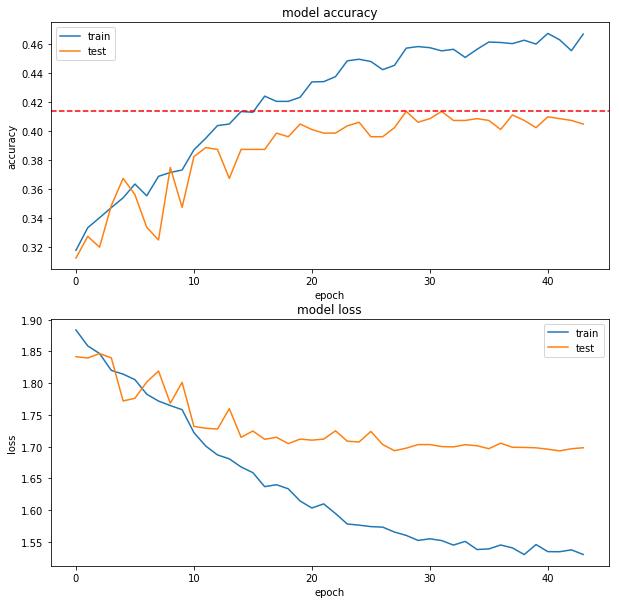

In [0]:
show_summary_stats(history, save=True, filename=os.path.join(colab_dir, 'figs/colab_test.png'))

Model is improving slightly. Up to 42% accuracy on validation set. Testing remains around 35% at best, which is better than random guessing.

White noise might make the classifier perform better, since some of the finer features of the song get washed out, and hence only the genre-defining features are noticable.

# Dwivedi's CRNN on the FMA-Medium Dataset

## Preprocessing (only run to build the npz files)

In [0]:
cols_to_keep = [('set','split'), ('set', 'subset'), ('track', 'genre_top')]
# ('track', 'genres') might be included to make a better model since some tracks don't have a top genre.

df_med = tracks[cols_to_keep]
df_med = df_med[ (df_med[('set','subset')] == 'small') | (df_med[('set','subset')] == 'medium') ]
df_med['track_id'] = df_med.index

In [0]:
df_med.head(10)

set                 track track_id
               split  subset     genre_top         
track_id                                           
2           training   small       Hip-Hop        2
3           training  medium       Hip-Hop        3
5           training   small       Hip-Hop        5
10          training   small           Pop       10
134         training  medium       Hip-Hop      134
136         training  medium          Rock      136
139         training  medium          Folk      139
140         training   small          Folk      140
141         training   small          Folk      141
148       validation   small  Experimental      148

In [0]:
print(len(df_med))

25000


In [0]:
# med_track_ids = track_id_from_directory(audio_dir_med)

In [0]:
# len(med_track_ids)

In [0]:
# X_1, sample_rates, y_1, split_labels = prepare_mp3s_and_labels(audio_dir_med, med_track_ids[:5000], df_med)

In [0]:
# print(X_1.shape, y_1.shape)

(4998, 1, 22050) (4998,)


In [0]:
# np.savez('med_processed_arr_1.npz', X_1, y_1, split_labels, sample_rates)

In [0]:
# don't want to eat up too much memory.

# del X_1
# del sample_rates
# del y_1
# del split_labels

In [0]:
# X_2, sample_rates, y_2, split_labels = prepare_mp3s_and_labels(audio_dir_med, med_track_ids[5000:10000], df_med)

In [0]:
# print(X_2.shape, y_2.shape)

(4994, 1, 22050) (4994,)


In [0]:
# np.savez('med_processed_arr_2.npz', X_2, y_2, split_labels, sample_rates)

In [0]:
# del X_2
# del sample_rates
# del y_2
# del split_labels

In [0]:
# X_3, sample_rates, y_3, split_labels = prepare_mp3s_and_labels(audio_dir_med, med_track_ids[10000:15000], df_med)

In [0]:
# print(X_3.shape, y_3.shape)

(4996, 1, 32000) (4996,)


In [0]:
# np.savez('med_processed_arr_3.npz', X_3, y_3, split_labels, sample_rates)

In [0]:
# del X_3
# del sample_rates
# del y_3
# del split_labels

In [0]:
# X_4, sample_rates, y_4, split_labels = prepare_mp3s_and_labels(audio_dir_med, med_track_ids[15000:20000], df_med)

In [0]:
# print(X_4.shape, y_4.shape)

(4999, 1, 22050) (4999,)


In [0]:
# np.savez('med_processed_arr_4.npz', X_4, y_4, split_labels, sample_rates)

In [0]:
# del X_4
# del sample_rates
# del y_4
# del split_labels

In [0]:
# X_5, sample_rates, y_5, split_labels = prepare_mp3s_and_labels(audio_dir_med, med_track_ids[20000:25000], df_med)

In [0]:
# print(X_5.shape, y_5.shape)

(4999, 1, 44100) (4999,)


In [0]:
# np.savez('med_processed_arr_5.npz', X_5, y_5, split_labels, sample_rates)

In [0]:
# del X_5
# del sample_rates
# del y_5
# del split_labels

## Importing the npz files and combining

In [0]:
npzfiles = [np.load(os.path.join(colab_dir, 'med_processed_arr_'+str(i+1)+'.npz')) for i in range(5)]

X_full=[]
y_full=[]
split_labels=[]
shapes=[]
for i in range(5):
    X_full.append(npzfiles[i]['arr_0'])
    print('X[%s] has shape %s.' % (i, X_full[i].shape))
    y_full.append(npzfiles[i]['arr_1'])
    print('y[%s] has shape %s.' % (i, y_full[i].shape))
    split_labels.append(npzfiles[i]['arr_2'])
    
    shapes.append(X_full[i].shape[2])
    
min_song_len = min(shapes)
for i in range(5):
    X_full[i] = X_full[i][:,:, :min_song_len]

for i in range(5):
    print(X_full[i].shape)
    
X_full = np.concatenate(X_full, axis=0)
print(X_full.shape)

y_full = np.concatenate(y_full, axis=0)
y_full = np.array([dict_genres_med[genre] for genre in y_full])
print(y_full.shape)

split_labels = np.array([train_type for chunk in split_labels for train_type in chunk])

Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7f2fe42f5f98>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 225, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected
Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7f2fe42f5400>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 225, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected
Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7f2fe42f50b8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6

X[0] has shape (4998, 1, 22050).
y[0] has shape (4998,).
X[1] has shape (4994, 1, 22050).
y[1] has shape (4994,).
X[2] has shape (4996, 1, 32000).
y[2] has shape (4996,).
X[3] has shape (4999, 1, 22050).
y[3] has shape (4999,).
X[4] has shape (4999, 1, 44100).
y[4] has shape (4999,).
(4998, 1, 22050)
(4994, 1, 22050)
(4996, 1, 22050)
(4999, 1, 22050)
(4999, 1, 22050)
(24986, 1, 22050)
(24986,)


Write the code to split into test and train.

In [0]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_val_test_split(X_full, y_full, split_labels)

In [0]:
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(19859, 1, 22050) (19859,) (2522, 1, 22050) (2522,) (2605, 1, 22050) (2605,)


## Parameters

In [0]:
batch_size = 32
num_classes = 16
# n_features = X_train.shape[2]
# n_time = X_train.shape[1]

N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 60 
NUM_HIDDEN = 64
L2_regularization = 0.001
drop_prob=0.3
adam_lr_init = 0.001

## Model Training and Testing

In [0]:
def create_crnn_model():
    print('Creating Model...')
    input_shape = X_full.shape[1:]
    sr = X_full.shape[2]

    model = Sequential()
    # A mel-spectrogram layer
    model.add(Melspectrogram(n_dft=2048,
                             n_hop=1024,
                             input_shape=input_shape,
                             padding='same',
                             sr=sr,
                             n_mels=128,
                             fmin=0.0,
                             fmax=sr/2,
                             power_melgram=1.0,
                             return_decibel_melgram=True,
                             trainable_fb=False,
                             trainable_kernel=False,
                             name='trainable_stft'))

    # Maybe some additive white noise.
#     model.add(AdditiveNoise(power=0.2))

    # If you wanna normalise it per-frequency
#     model.add(Normalization2D(str_axis='freq')) # or 'channel', 'time', 'batch', 'data_sample'

    # After this, it's just a usual keras workflow. For example..
    # Add some layers, e.g., model.add(some convolution layers..)

    # Lambda layer to strip off the dimension of size 1.
    model.add(
        Lambda(lambda x: x[:,:,:,0])
    )

    # Dwivedi's Model
    # 3 1D convolutional layers
    for i in range(N_LAYERS):
        model.add( Conv1D( filters=CONV_FILTER_COUNT, kernel_size=FILTER_LENGTH, kernel_regularizer=regularizers.l2(L2_regularization), name='convolution_'+str(i+1) ) )
        model.add( BatchNormalization(momentum=0.9) )
        model.add( Activation('relu') )
        model.add( MaxPooling1D(2) )
        model.add( Dropout(drop_prob) )

    # LSTM layer

    model.add( LSTM(LSTM_COUNT, return_sequences=False) )
    model.add( Dropout(drop_prob) )

    # Dense layer
    model.add( Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1') )
    model.add( Dropout(drop_prob) )

    # softmax output
    model.add( Dense(num_classes) )
    model.add( Activation('softmax', name='output_layer') )


    return model

In [0]:
crnn_model = create_crnn_model()

print(crnn_model.summary())

Creating Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trainable_stft (Melspectrogr (None, 128, 22, 1)        4329600   
_________________________________________________________________
lambda_4 (Lambda)            (None, 128, 22)           0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, 124, 56)           6216      
_________________________________________________________________
batch_normalization_10 (Batc (None, 124, 56)           224       
_________________________________________________________________
activation_10 (Activation)   (None, 124, 56)           0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 62, 56)            0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 62, 56)            0  

In [0]:
history = train_and_fit(crnn_model, X_train, y_train, X_valid, y_valid, X_test, y_test, lr = adam_lr_init, batch_size=batch_size, num_epochs=70)


Epoch 00001: val_acc improved from -inf to 0.39056, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00002: val_acc did not improve from 0.39056



Epoch 00003: val_acc improved from 0.39056 to 0.44766, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00004: val_acc improved from 0.44766 to 0.47264, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00005: val_acc did not improve from 0.47264



Epoch 00006: val_acc did not improve from 0.47264



Epoch 00007: val_acc did not improve from 0.47264



Epoch 00008: val_acc did not improve from 0.47264



Epoch 00009: val_acc improved from 0.47264 to 0.48414, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00010: val_acc did not improve from 0.48414



Epoch 00011: val_acc improved from 0.48414 to 0.49405, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00012: val_acc did not improve from 0.49405



Epoch 00013: val_acc improved from 0.49405 to 0.50397, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00014: val_acc improved from 0.50397 to 0.51308, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00015: val_acc did not improve from 0.51308



Epoch 00016: val_acc did not improve from 0.51308



Epoch 00017: val_acc did not improve from 0.51308



Epoch 00018: val_acc improved from 0.51308 to 0.51427, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00019: val_acc did not improve from 0.51427



Epoch 00020: val_acc did not improve from 0.51427



Epoch 00021: val_acc did not improve from 0.51427



Epoch 00022: val_acc did not improve from 0.51427



Epoch 00023: val_acc did not improve from 0.51427

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 00024: val_acc improved from 0.51427 to 0.53608, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00025: val_acc improved from 0.53608 to 0.54758, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00026: val_acc did not improve from 0.54758



Epoch 00027: val_acc did not improve from 0.54758



Epoch 00028: val_acc did not improve from 0.54758



Epoch 00029: val_acc did not improve from 0.54758



Epoch 00030: val_acc improved from 0.54758 to 0.55155, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.



Epoch 00031: val_acc did not improve from 0.55155



Epoch 00032: val_acc improved from 0.55155 to 0.55393, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00033: val_acc improved from 0.55393 to 0.56463, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00034: val_acc did not improve from 0.56463



Epoch 00035: val_acc did not improve from 0.56463



Epoch 00036: val_acc did not improve from 0.56463



Epoch 00037: val_acc improved from 0.56463 to 0.56542, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00038: val_acc did not improve from 0.56542

Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.



Epoch 00039: val_acc did not improve from 0.56542



Epoch 00040: val_acc did not improve from 0.56542



Epoch 00041: val_acc did not improve from 0.56542



Epoch 00042: val_acc did not improve from 0.56542



Epoch 00043: val_acc did not improve from 0.56542

Epoch 00043: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.



Epoch 00044: val_acc did not improve from 0.56542



Epoch 00045: val_acc improved from 0.56542 to 0.56661, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00046: val_acc did not improve from 0.56661



Epoch 00047: val_acc did not improve from 0.56661



Epoch 00048: val_acc did not improve from 0.56661

Epoch 00048: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.



Epoch 00049: val_acc did not improve from 0.56661



Epoch 00050: val_acc did not improve from 0.56661



Epoch 00051: val_acc did not improve from 0.56661



Epoch 00052: val_acc did not improve from 0.56661



Epoch 00053: val_acc did not improve from 0.56661

Epoch 00053: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.



Epoch 00054: val_acc did not improve from 0.56661



Epoch 00055: val_acc did not improve from 0.56661



Epoch 00056: val_acc did not improve from 0.56661



Epoch 00057: val_acc did not improve from 0.56661



Epoch 00058: val_acc improved from 0.56661 to 0.56820, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5

Epoch 00058: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.



Epoch 00059: val_acc improved from 0.56820 to 0.56899, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00060: val_acc did not improve from 0.56899



Epoch 00061: val_acc did not improve from 0.56899



Epoch 00062: val_acc did not improve from 0.56899



Epoch 00063: val_acc did not improve from 0.56899

Epoch 00063: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.



Epoch 00064: val_acc did not improve from 0.56899



Epoch 00065: val_acc did not improve from 0.56899



Epoch 00066: val_acc did not improve from 0.56899



Epoch 00067: val_acc improved from 0.56899 to 0.56939, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5



Epoch 00068: val_acc did not improve from 0.56939

Epoch 00068: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.



Epoch 00069: val_acc did not improve from 0.56939



Epoch 00070: val_acc improved from 0.56939 to 0.56979, saving model to /content/drive/My Drive/music_npz_files/models/crnn/weights.best.h5
Validation loss: 1.45 -- acc: 0.57
Test loss: 1.74 -- acc: 0.50


dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


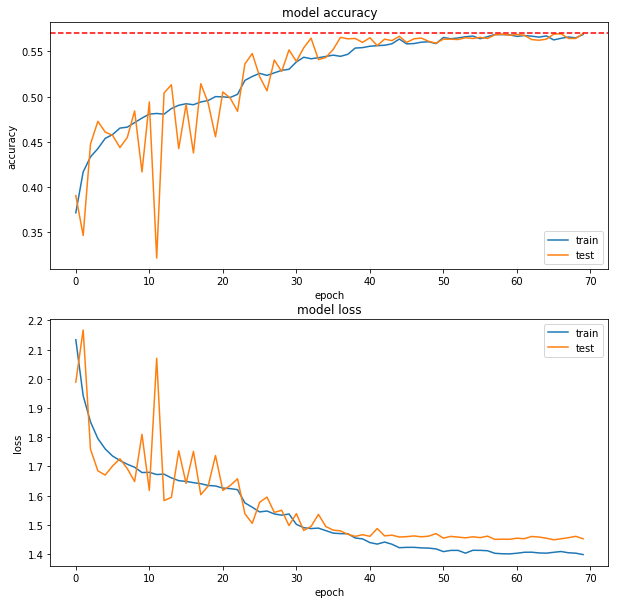

In [0]:
show_summary_stats(history, save=True, filename=os.path.join(colab_dir, 'figs/med_2.png'))

Now the model is up to 51%! Incredible.
Might try to implement Dwivedi's other model, or the model from the paper. 